In [1]:
import pandas as pd
import xgboost as xbg
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.datasets import  make_classification
from itertools import cycle
from keras.utils import to_categorical

In [2]:
# def plot_results(y_test, y_pred, model ):
#     acc = metrics.accuracy_score(y_test, y_pred)
#     f1 = metrics.f1_score(y_test, y_pred, average='macro')
#     y_pred_onehot = pd.get_dummies(y_pred)
#     roc_auc = metrics.roc_auc_score(y_test, y_pred_onehot, multi_class='ovo')
#     print('Model performance for {model}'.format(model=model))
#     print('------------------------------------------------')
#     print('Accuracy is ', acc)
#     print('F1 is ', f1)
#     print('ROC AUC Score is ', roc_auc)
#     print('------------------------------------------------')

#     # metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
#     metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
#     plt.show()
#     df = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))
#     df2 = df.div(df.sum(axis=1), axis=0)
#     ax = sns.heatmap(df2)
#     ax.set(xlabel='Predicted', ylabel='Actual', title=f'Confusion Matrix for {model}')
#     plt.show()
  

In [2]:
def calc_roc_curve(y_test, y_score, classifier):
    if classifier == "1":
        n_classes = 2
    else:
        n_classes = y_test.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

   
    return fpr, tpr, roc_auc, n_classes

In [4]:
# def calc_roc_curve(y_test, y_pred):
#   n_classes = len(np.unique(y_test))
#   y_test = label_binarize(y_test, classes=np.arange(n_classes))
#   y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

#   # Code for MultiClass ROC Curve from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
#   # Compute ROC curve and ROC area for each class
#   fpr = dict()
#   tpr = dict()
#   roc_auc = dict()
#   thresholds = dict()
#   for i in range(n_classes):
#     fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
#     roc_auc[i] = auc(fpr[i], tpr[i])

#   # Compute micro-average ROC curve and ROC area
#   fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
#   roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#   # First aggregate all false positive rates
#   all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#   # Then interpolate all ROC curves at this points
#   mean_tpr = np.zeros_like(all_fpr)
#   for i in range(n_classes):
#     mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#   # Finally average it and compute AUC
#   mean_tpr /= n_classes

#   fpr["macro"] = all_fpr
#   tpr["macro"] = mean_tpr
#   roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#   return fpr, tpr, roc_auc, n_classes

In [69]:
# def reorder(y_test, y_pred):
#     #change label 0 to 1 and vice versa
#     y_test = np.where(y_test == 0, 4, y_test)
#     y_test = np.where(y_test == 1, 0, y_test)
#     y_test = np.where(y_test == 4, 1, y_test)

#     y_pred = np.where(y_pred == 0, 4, y_pred)
#     y_pred = np.where(y_pred == 1, 0, y_pred)
#     y_pred = np.where(y_pred == 4, 1, y_pred)

#     return y_test, y_pred

In [3]:
def plot_results_b(y_test, y_pred, model, perf_class, classifier="2"):
    if classifier == "1":
        labels = {0: "Non-Covid", 1: "Covid"}
    elif classifier == "2":
        labels = {0: "Anti-Vaccine", 1: "Neutral", 2: "Pro-Vaccine"}
    fig = plt.figure(f"{model} Performance Evaluation", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)
    font = {"weight": "bold"}
    fpr, tpr, roc_auc, n_classes = calc_roc_curve(y_test, y_pred, classifier)
    ax0 = fig.add_subplot(axgrid[0:3, :])

    ax0.set_title(f"Receiver Operating Characteristic (ROC) Curve for {model}", fontdict=font)
     # Plot all ROC curves
    # ax0.figure(figsize=(3,3))
    # ax0.figure(dpi=600)
    lw = 2

     # Plot all ROC curves
    ax0.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    ax0.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        ax0.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(labels[i], roc_auc[i]),
        )

    ax0.plot([0, 1], [0, 1], "k--", lw=lw)
    ax0.set_xlim([0.0, 1.0])
    ax0.set_ylim([0.0, 1.05])
    ax0.set_xlabel("False Positive Rate")
    ax0.set_ylabel("True Positive Rate")
   
    ax0.legend(loc="lower right")

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.set_title("Confusion Matrics", fontdict=font)
    y_score_max = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
    y_score_label = np.argmax(y_score_max, axis=1)
    y_test_label = np.argmax(y_test, axis=1)
    df = pd.DataFrame(metrics.confusion_matrix(y_test_label, y_score_label))
    df2 = df.div(df.sum(axis=1), axis=0)
    ax1 = sns.heatmap(df2, annot=True)
    ax1.set(xlabel='Predicted', ylabel='Actual', xticklabels=labels.values(), yticklabels=labels.values())
    ax1.set_title("Confusion matrix", fontdict=font)

    ax2 = fig.add_subplot(axgrid[3:, 2:])
    acc = metrics.accuracy_score(y_test_label, y_score_label)
    f1 = metrics.f1_score(y_test_label, y_score_label, average='macro')
    roc_auc = metrics.roc_auc_score(y_test, y_score_max, multi_class='ovo')
    ax2.set_title("Performance Metrics", fontdict=font )
    ax2.text(0.23, 0.85, f"Model: {model}", fontdict=font)
    ax2.text(0.23, 0.75, f"Model Type: {perf_class}")
    ax2.text(0.18, 0.68, "--------------------------------------------------")
    ax2.text(0.23, 0.6, f"Accuracy is {round(acc, 3)}")
    ax2.text(0.23, 0.5, f"F1 is {round(f1,3)}")
    ax2.text(0.23, 0.4, f"ROC-AUC is {round(roc_auc, 3)}")
    ax2.text(0.18, 0.33, "---------------------------------------------------")
    # ax2.text(0.23, 0.25, "Label Legend: ", fontdict=font )
    
    # ax2.text(0.23, 0.15, "Class 0: Anti-Vaccine")
    # ax2.text(0.23, 0.05, "Class 1: Neutral / Noise")
    # ax2.text(0.23, -0.05, "Class 2: Pro-Vaccine")
  
    ax2.set_axis_off()

    fig.tight_layout()
    plt.show()

## Classifier I

In [163]:
y_true = pd.read_csv('../../Files/Submissions/train/test1.csv', sep='|')
y_true = to_categorical(y_true['label'], 2)

### XGBoost

In [164]:
y_pred_xgb = np.loadtxt('../../Files/models/xgboostC1.txt')
y_pred_xgb = y_pred_xgb.reshape(2743, 2)

In [103]:
import scikitplot as skplt

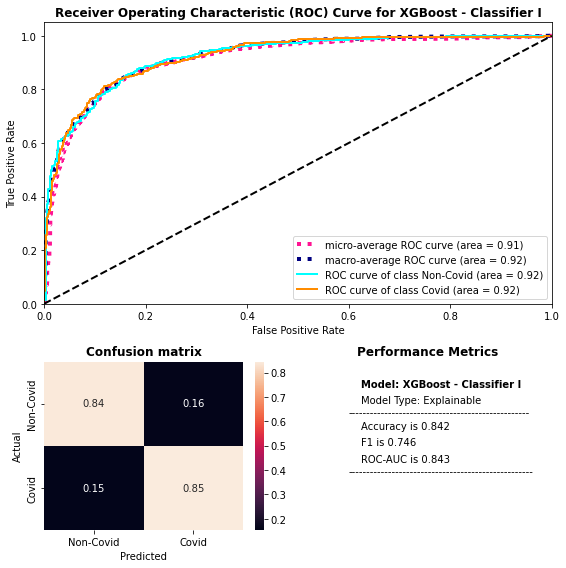

In [151]:
plot_results_b(y_true, y_pred_xgb, "XGBoost - Classifier I", "Explainable", "1")

### CNN

In [165]:
y_pred_cnn = np.loadtxt('../../Files/models/cnn_C1_results.txt')
y_pred_cnn = y_pred_cnn.reshape(2743, 2)
y_pred_cnn.shape

(2743, 2)

In [166]:
y_score_max = (y_pred_cnn == y_pred_cnn.max(axis=1)[:,None]).astype(int)
y_score_label = np.argmax(y_score_max, axis=1)
y_test_label = np.argmax(y_true, axis=1)

<AxesSubplot:>

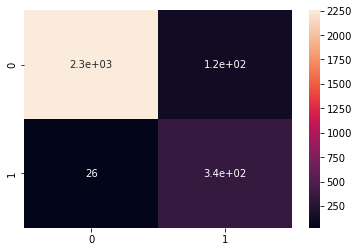

In [167]:
df = pd.DataFrame(metrics.confusion_matrix(y_test_label, y_score_label))
sns.heatmap(df, annot=True)

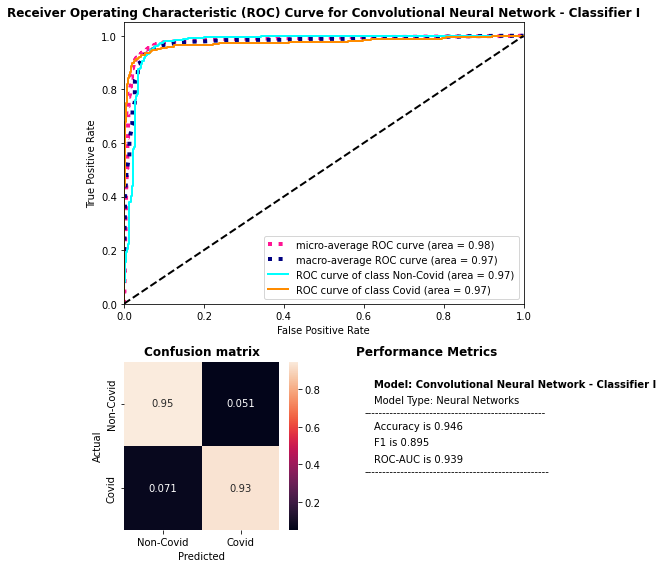

In [155]:
plot_results_b(y_true, y_pred_cnn, "Convolutional Neural Network - Classifier I", "Neural Networks", "1")

## Classifier II

In [4]:
y_true = pd.read_csv('../../Files/Submissions/train/test2.csv', sep='|')
y_true = to_categorical(y_true['label'], 3)

### Explainable

#### XGBOOST

In [157]:
y_pred_xgb = np.loadtxt('../../Files/models/xgboostC2.txt')


In [158]:
y_true.shape

(368, 3)

In [159]:
y_pred_xgb = y_pred_xgb.reshape(368, 3)

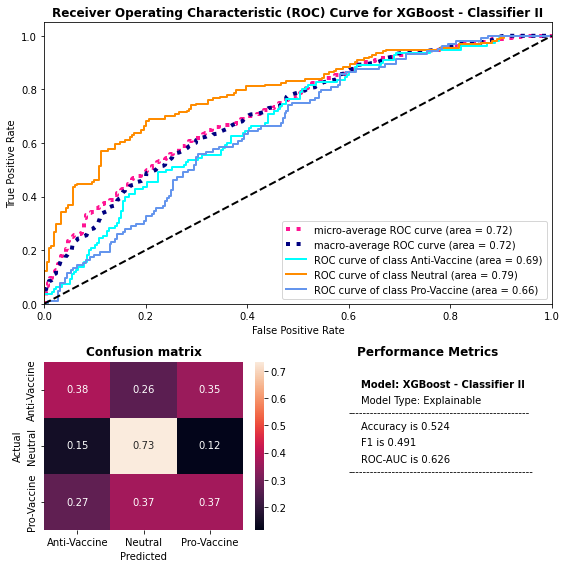

In [160]:
plot_results_b(y_true, y_pred_xgb, "XGBoost - Classifier II", "Explainable", "2")

### NN

#### CNN

In [161]:
y_pred_cnn = np.loadtxt('../../Files/models/cnn_comments_results.txt')
y_pred_cnn = y_pred_cnn.reshape(368, 3)
y_pred_cnn.shape

(368, 3)

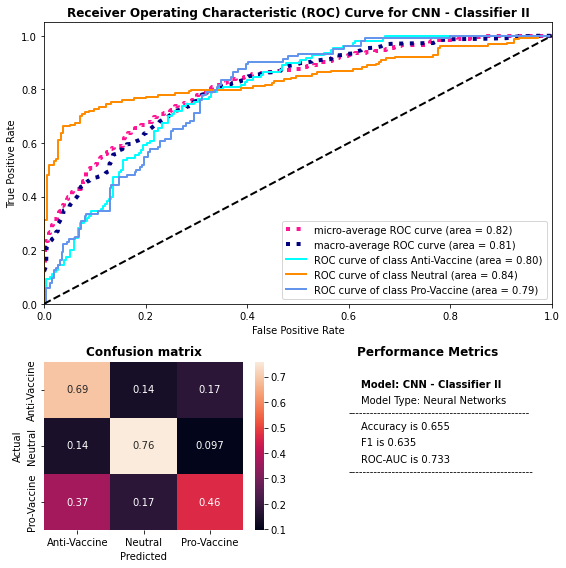

In [162]:
plot_results_b(y_true, y_pred_cnn, "CNN - Classifier II", "Neural Networks", "2")

#### RoBERTa

In [5]:
y_pred = pd.read_csv('../../Files/models/Roberta_C2.csv', sep='|')['pred_1']

In [6]:
y_true.shape

(368, 3)

In [7]:
tests_1hot = to_categorical(y_pred )

In [8]:
tests_1hot.shape

(368, 3)

In [9]:
tests_1hot

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [10]:
y_conf = pd.read_csv('../../Files/models/Roberta_C2.csv', sep='|')['conf_1']

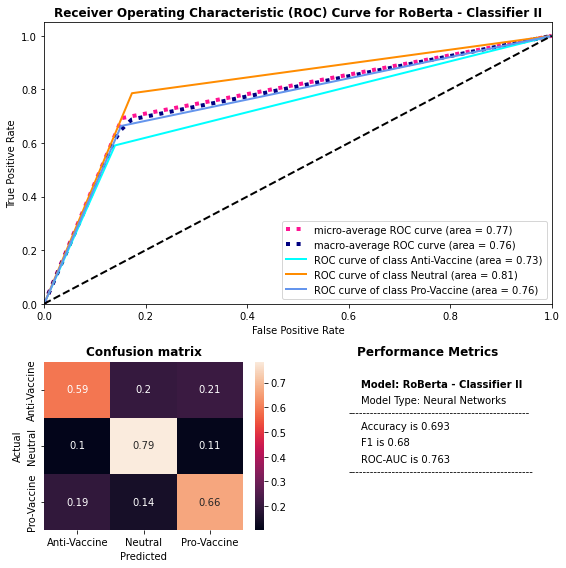

In [19]:
plot_results_b(y_true, tests_1hot, "RoBerta - Classifier II", "Neural Networks", "2")

# DEPRECATED: FIRST TRAINED CLASSIFIER

## Explainable Models

### Linear Regression

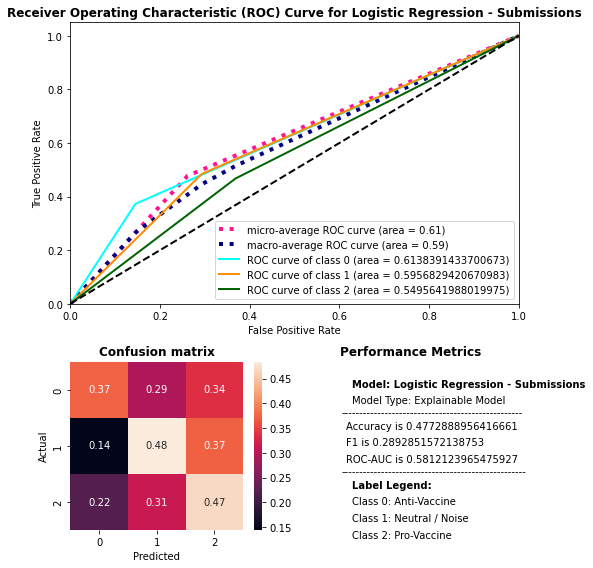

In [160]:
plot_results_b(y_true, y_pred, 'Logistic Regression - Submissions', "Explainable Model")

### XGBoost

In [157]:
y_pred = np.fromfile('../../Files/models/xgb_test.txt', sep=' ')

In [104]:
y_pred.shape

(1408474,)

## Neural Networks

### CNN

In [155]:
y_pred = np.loadtxt('../../Files/models/cnn_results.txt')
y_pred = y_pred.reshape(1408474, 3)
y_pred = y_pred.round()
y_pred = np.argmax(y_pred, axis=1)

In [161]:
y_pred = np.loadtxt('../../Files/models/cnn_results2.txt')

### Pre-trained BERT: BERT base cased

In [80]:
df = pd.read_pickle('../../Files/models/bert_base_cased_model/fully_trained/bert_base_cased_predictions.pickle')

In [98]:
y_pred = []
for i, j in df.iterrows():
    y_pred.append(int(df[0][i]['label'][-1]))

In [ ]:
y_true, y_pred = reorder(y_true, y_pred)

### BERT 2

In [115]:
df = pd.read_pickle('../../Files/models/bert_base_cased_model/fully_trained/bert_base_cased_predictions2.pickle')

In [130]:
y_pred = []
for i, j in df.iterrows():
    y_pred.append(int(df[0][i]['label'][-1]))

In [151]:
y_true = pd.read_csv('../../Files/models/y_true.csv')
y_true.reset_index(drop=True, inplace=True)
y_true = y_true.to_numpy()
y_true = y_true.flatten()

In [134]:
y_pred = np.where(y_pred == 0, 4, y_pred)
print("done")

done


In [136]:
y_pred = np.where(y_pred == 1, 0, y_pred)
print("done")
y_pred = np.where(y_pred == 4, 1, y_pred)


done


In [137]:
np.unique(y_pred)

array([0, 1, 2])

In [144]:
y_true = np.where(y_true == 0, 4, y_true)
y_true = np.where(y_true == 1, 0, y_true)
y_true = np.where(y_true == 4, 1, y_true)

In [145]:
np.unique(y_true)

array([0, 1, 2])

### pre-trained Twitter RoBERTa Submissions

In [147]:
df = pd.read_pickle('/Users/jakobschlierf/Desktop/Master/Thesis/Files/models/chp43125s.pickle')

### pre-trained Twitter RoBERTa Comments

In [63]:
df2 = pd.read_pickle('/Users/jakobschlierf/Desktop/Master/Thesis/Files/models/chp63750.pickle')